In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-8])

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
from ACME.ACME import ACME
import numpy as np
import pandas as pd

In [5]:
mean = [5,5,5,5,5,5]
cov = np.identity(6)
x_normal = pd.DataFrame(np.random.multivariate_normal(mean, cov, 10000), columns = ['f'+str(i) for i in range(1,7)] )
x_normal['is_out'] = 0

In [6]:
mean = [10,10,8,5,5,5]
cov = np.identity(6)
x_outliers =  pd.DataFrame(np.random.multivariate_normal(mean, cov, 500), columns = ['f'+str(i) for i in range(1,7)] )
x_outliers['is_out'] = 1

In [7]:
X = pd.concat([x_normal,x_outliers],ignore_index=True, sort=False).reset_index(drop=True)

In [8]:
features = ['f'+str(i) for i in range(1,7)]

In [9]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(random_state=0).fit(X[features])

In [10]:
def score_function(model, data):
    try: # for global
        df = model.decision_function(data)
    except: # for local
        df = model.decision_function(data.reshape(1,-1))
    
    return (-1*df+1)/2

In [11]:
X['pred_AD_score'] = score_function(if_model,X[features])
X.tail()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10495,11.265497,10.328011,9.457271,6.265355,4.646915,4.456828,1,0.567362
10496,11.543649,9.652575,7.432133,5.042672,4.796317,4.165892,1,0.547494
10497,9.098799,9.174965,8.449793,5.571504,5.468342,4.218134,1,0.529947
10498,11.747237,7.986571,7.856401,4.617198,5.631927,5.838829,1,0.557666
10499,10.719534,9.882023,8.536154,3.690338,4.296108,3.804345,1,0.562563


In [12]:
X.loc[X.is_out == 1].sort_values('f1').head()

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10314,7.453705,10.939575,6.959662,4.258099,4.283132,5.532137,1,0.510450
10152,7.516631,11.507675,7.777983,2.812145,5.800358,5.055627,1,0.554762
10220,7.517473,9.287993,8.464953,5.033077,6.389728,4.575395,1,0.523883
10165,7.655367,8.970518,8.686381,3.146980,6.146392,4.739390,1,0.539662
10284,7.760573,11.669692,8.612592,4.396135,4.117168,6.154128,1,0.544557


<AxesSubplot:ylabel='Frequency'>

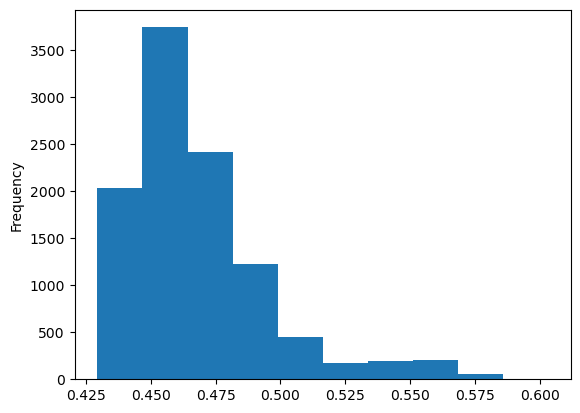

In [13]:
X['pred_AD_score'].plot(kind='hist')

In [14]:
half_anomalies = pd.DataFrame(X.loc[10379]).T

In [15]:
half_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10379,9.335085,12.478959,8.09049,4.112437,4.454872,4.266958,1.0,0.56254


In [16]:
bottom_anomalies = X.loc[(X['pred_AD_score']>0.5)].sort_values(by='pred_AD_score', ascending=False).tail(10)
top_anomalies = X.loc[(X['pred_AD_score']>0.5)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [17]:
top_normal = X.loc[(X['pred_AD_score']<0.5)].sort_values(by='pred_AD_score', ascending=False).tail(10)
bottom_normal = X.loc[(X['pred_AD_score']<0.5)].sort_values(by='pred_AD_score', ascending=False).head(10)

In [18]:
top_anomalies

,f1,f2,f3,f4,f5,f6,is_out,pred_AD_score
10409,10.441624,11.612668,8.937538,5.711617,6.834741,7.808373,1,0.603277
10412,9.824486,11.241251,7.711528,6.216061,7.268653,6.979687,1,0.594219
10116,10.201562,10.418861,9.870609,3.421767,2.481017,6.011905,1,0.587881
10281,10.786208,11.574455,9.210861,6.832415,5.434046,3.315160,1,0.587557
10092,11.631306,10.097511,8.541862,7.127816,4.900931,7.139980,1,0.587289
10442,11.889657,11.766999,8.772289,4.542291,5.576926,6.561733,1,0.586661
10185,10.638109,12.847193,9.189847,5.794833,3.401100,3.207199,1,0.584878
10203,11.485570,11.258605,8.654330,4.245928,4.563039,6.431092,1,0.584034
10139,10.282225,11.592886,10.089493,3.283096,5.508490,3.937136,1,0.583180
10287,11.403895,12.427817,9.487215,6.234831,4.608243,5.020962,1,0.582676


In [19]:
k = 20
acme_ifo = ACME(model = if_model, target = 'AD_score', K=k, task='ad', score_function=score_function, features=features)
acme_ifo = acme_ifo.explain(X[features], robust = True)

In [20]:
acme_ifo.feature_importance()

,importance
feature,
f1,0.010975
f2,0.008993
f3,0.008244
f5,0.007180
f4,0.007110
f6,0.004877


In [21]:
acme_ifo.summary_plot()

In [22]:
acme_local = acme_ifo.explain_local(X[features].loc[half_anomalies.index[-1]])

In [23]:
acme_local.summary_table(local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,importance
feature,,,,,,,,,
f1,0.964762,9.335085,numeric,0.562540,0.56254,0.000000,0.964762,None,0.024866
f1,0.050000,3.354788,numeric,0.538879,0.56254,-0.023661,0.964762,None,0.024866
f1,0.100000,3.751245,numeric,0.537874,0.56254,-0.024667,0.964762,None,0.024866
f1,0.150000,3.990356,numeric,0.538235,0.56254,-0.024306,0.964762,None,0.024866
f1,0.200000,4.191394,numeric,0.535316,0.56254,-0.027224,0.964762,None,0.024866
...,...,...,...,...,...,...,...,...,...
f6,0.750000,5.687428,numeric,0.557487,0.56254,-0.005053,0.231429,None,0.002814
f6,0.800000,5.854219,numeric,0.559325,0.56254,-0.003215,0.231429,None,0.002814
f6,0.850000,6.056788,numeric,0.559553,0.56254,-0.002988,0.231429,None,0.002814


In [24]:
acme_local.feature_importance()

,importance
feature,
f1,0.010975
f2,0.008993
f3,0.008244
f5,0.007180
f4,0.007110
f6,0.004877


In [25]:
acme_local.feature_importance(local=True, weights = {'ratio':0.1,'delta':0.1,'change':0.3,'distance':0.5})

,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f2,0.038566,0.038566,0.0,1.0,0.562540,0.523975,0.56254,0.007713
f1,0.030348,0.030348,0.0,1.0,0.562540,0.532192,0.56254,0.006070
f3,0.017860,0.017860,0.0,1.0,0.562540,0.544681,0.56254,0.003572
f4,0.007270,0.016085,0.0,1.0,0.571355,0.555270,0.56254,0.002336
f5,0.006764,0.013527,0.0,1.0,0.569303,0.555776,0.56254,0.002029
f6,0.005594,0.009253,0.0,1.0,0.566200,0.556947,0.56254,0.001485


In [26]:
acme_local.feature_importance(local=True)

Using default weights for anomaly detection feature importance


,ratio,delta,change,distance_to_change,max_score,min_score,local_score,importance
f2,0.038566,0.038566,0.0,1.0,0.562540,0.523975,0.56254,0.019283
f1,0.030348,0.030348,0.0,1.0,0.562540,0.532192,0.56254,0.015174
f3,0.017860,0.017860,0.0,1.0,0.562540,0.544681,0.56254,0.008930
f4,0.007270,0.016085,0.0,1.0,0.571355,0.555270,0.56254,0.006280
f5,0.006764,0.013527,0.0,1.0,0.569303,0.555776,0.56254,0.005411
f6,0.005594,0.009253,0.0,1.0,0.566200,0.556947,0.56254,0.003895


In [27]:
acme_local.summary_plot(local=True)

Using default weights for anomaly detection feature importance


In [28]:
acme_local.feature_exploration('f1',local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,size,importance,direction
feature,,,,,,,,,,,
f1,0.964762,9.335085,numeric,0.562540,0.56254,0.000000,0.964762,None,0.30,0.024866,anomalies
f1,0.050000,3.354788,numeric,0.538879,0.56254,-0.023661,0.964762,None,0.05,0.024866,anomalies
f1,0.100000,3.751245,numeric,0.537874,0.56254,-0.024667,0.964762,None,0.05,0.024866,anomalies
f1,0.150000,3.990356,numeric,0.538235,0.56254,-0.024306,0.964762,None,0.05,0.024866,anomalies
f1,0.200000,4.191394,numeric,0.535316,0.56254,-0.027224,0.964762,None,0.05,0.024866,anomalies
f1,0.250000,4.371868,numeric,0.532926,0.56254,-0.029615,0.964762,None,0.05,0.024866,anomalies
f1,0.300000,4.535139,numeric,0.532348,0.56254,-0.030192,0.964762,None,0.05,0.024866,anomalies
f1,0.350000,4.675773,numeric,0.533276,0.56254,-0.029264,0.964762,None,0.05,0.024866,anomalies
f1,0.400000,4.808250,numeric,0.532192,0.56254,-0.030348,0.964762,None,0.05,0.024866,anomalies


In [29]:
acme_local.feature_exploration('f3',local=True,plot=True)

In [30]:
acme_local.baseline_values()

,f1,f2,f3,f4,f5,f6
0,5.250157,5.235323,5.134606,4.998712,4.993661,5.006479


In [31]:
acme_local.baseline_values(local=True)

,f1,f2,f3,f4,f5,f6
10379,9.335085,12.478959,8.09049,4.112437,4.454872,4.266958


In [32]:
acme_local.summary_table(local=True)

,quantile,original,type_feature,predict,baseline_prediction,effect,baseline_quantile,class,importance
feature,,,,,,,,,
f1,0.964762,9.335085,numeric,0.562540,0.56254,0.000000,0.964762,None,0.024866
f1,0.050000,3.354788,numeric,0.538879,0.56254,-0.023661,0.964762,None,0.024866
f1,0.100000,3.751245,numeric,0.537874,0.56254,-0.024667,0.964762,None,0.024866
f1,0.150000,3.990356,numeric,0.538235,0.56254,-0.024306,0.964762,None,0.024866
f1,0.200000,4.191394,numeric,0.535316,0.56254,-0.027224,0.964762,None,0.024866
...,...,...,...,...,...,...,...,...,...
f6,0.750000,5.687428,numeric,0.557487,0.56254,-0.005053,0.231429,None,0.002814
f6,0.800000,5.854219,numeric,0.559325,0.56254,-0.003215,0.231429,None,0.002814
f6,0.850000,6.056788,numeric,0.559553,0.56254,-0.002988,0.231429,None,0.002814
